# Dimensionality Reduction Analysis

Dit notebook analyseert de dataset met drie verschillende dimensionality reduction technieken:
- **PCA**: Principal Component Analysis - lineaire techniek die variantie maximaliseert
- **T-SNE**: t-Distributed Stochastic Neighbor Embedding - niet-lineaire techniek voor lokale structuur
- **UMAP**: Uniform Manifold Approximation and Projection - snel en bewaart globale en lokale structuur

In [1]:
# Importeer benodigde bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
import warnings
warnings.filterwarnings('ignore')

# Zet stijl
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

In [2]:
# Laad de dataset
df = pd.read_csv('Uitgebreide_VKM_dataset_cleaned.csv')

In [3]:
# Prepareer data voor dimensionality reduction
# Selecteer alleen numerieke kolommen
numeric_df = df.select_dtypes(include=[np.number])

print(f"Numerieke kolommen: {numeric_df.shape[1]}")
print(f"Voorbeelden: {numeric_df.shape[0]}")

# Handel de missende waarden af
numeric_df = numeric_df.fillna(numeric_df.mean())

# Standaardiseer de features (belangrijk voor alle drie methoden)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

print(f"\nData gestandaardiseerd. Shape: {X_scaled.shape}")

Numerieke kolommen: 7
Voorbeelden: 211

Data gestandaardiseerd. Shape: (211, 7)


## 1. PCA (Principal Component Analysis)

**Wat laat het zien:**
- PCA is een lineaire techniek die de datavariatie naar een kleiner aantal dimensies comprimert
- Het zoekt naar de richtingen (componenten) waarin de meeste variantie in de data zit
- Goed voor het begrijpen van welke features het meest belangrijk zijn
- Behoudt globale structuur, maar verliest mogelijk interessante lokale clusters

**Voordelen:**
- Snel en schaalbaar
- Interpreteerbaarheid (componenten zijn lineaire combinaties van features)
- Goed voor het zien van de algemene structuur van de data

In [4]:
# Pas PCA toe
print("PCA berekenen...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Maak een dataframe met PCA resultaten
pca_df = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2']
)

# Toon verklaarde variantie
print(f"Verklaarde Variantieverhouding:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"Totaal: {sum(pca.explained_variance_ratio_):.4f} ({sum(pca.explained_variance_ratio_)*100:.2f}%)")
print(f"\nTop 5 features die bijdragen aan PC1:")
pc1_contrib = pd.DataFrame(
    {'Feature': numeric_df.columns, 'Contribution': abs(pca.components_[0])}
).sort_values('Contribution', ascending=False)
print(pc1_contrib.head())

PCA berekenen...
Verklaarde Variantieverhouding:
PC1: 0.2722 (27.22%)
PC2: 0.1676 (16.76%)
Totaal: 0.4398 (43.98%)

Top 5 features die bijdragen aan PC1:
                 Feature  Contribution
2             contact_id      0.701650
0                     id      0.699348
4       popularity_score      0.106246
6        available_spots      0.062877
3  interests_match_score      0.040265


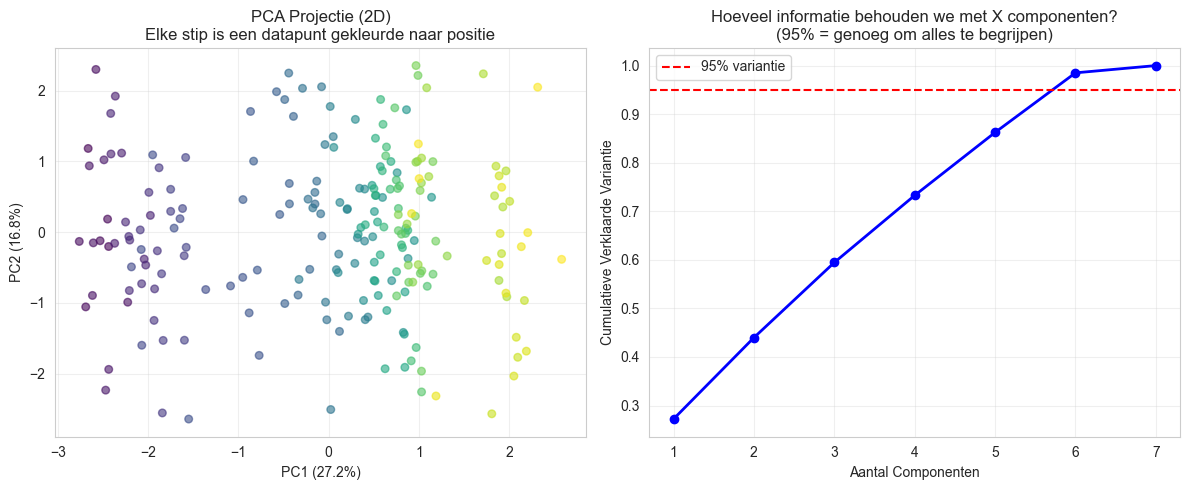

Originele dimensies: 7
Gereduceerd naar: 2 dimensies
Informatie behouden: 43.98%


In [5]:
# PCA Visualisatie
plt.figure(figsize=(12, 5))

# Grafiek 1: PCA scatter plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6, s=30, c=range(len(pca_df)), cmap='viridis')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA Projectie (2D)\nElke stip is een datapunt gekleurde naar positie')
plt.grid(True, alpha=0.3)

# Grafiek 2: Cumulatieve verklaarde variantie
plt.subplot(1, 2, 2)
pca_full = PCA()
pca_full.fit(X_scaled)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(cumsum) + 1), cumsum, 'bo-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variantie')
plt.xlabel('Aantal Componenten')
plt.ylabel('Cumulatieve Verklaarde Variantie')
plt.title('Hoeveel informatie behouden we met X componenten?\n(95% = genoeg om alles te begrijpen)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Originele dimensies: {X_scaled.shape[1]}")
print(f"Gereduceerd naar: 2 dimensies")
print(f"Informatie behouden: {sum(pca.explained_variance_ratio_)*100:.2f}%")

## 2. T-SNE (t-Distributed Stochastic Neighbor Embedding)

**Wat laat het zien:**
- T-SNE is een niet-lineaire techniek die lokale clusters en structuur bewaart
- Het probeert punten die dicht bij elkaar liggen in de originele ruimte ook dicht bij elkaar te houden in de 2D ruimte
- Erg goed voor het zien van clusters en groepen
- Kan misleidend zijn voor globale structuur (afstanden tussen clusters zijn niet altijd betekenisvol)

**Voordelen:**
- Reveals lokale cluster-structuur zeer duidelijk
- Goed voor exploratory data analysis
- Gebruikelijk in machine learning visualisaties

**Nadelen:**
- Traag voor grote datasets
- Niet deterministisch (verschillende runs geven andere resultaten)
- Globale afstanden zijn niet betekenisvol

In [6]:
# Pas T-SNE toe
print("Calculating T-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_scaled)

# Maak een dataframe met T-SNE resultaten
tsne_df = pd.DataFrame(
    X_tsne,
    columns=['TSNE1', 'TSNE2']
)

print(f"T-SNE transformatie voltooid")
print(f"Shape: {X_tsne.shape}")

# Check for clusters
from scipy.spatial.distance import pdist, squareform
distances = squareform(pdist(X_tsne))
avg_distance = np.mean(distances)
print(f"Gemiddelde afstand: {avg_distance:.2f}")

Calculating T-SNE (this may take a moment)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 211 samples in 0.000s...
[t-SNE] Computed neighbors for 211 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 211 / 211
[t-SNE] Mean sigma: 1.323364
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.081367
[t-SNE] KL divergence after 1000 iterations: 0.662582
T-SNE transformatie voltooid
Shape: (211, 2)
Gemiddelde afstand: 12.81


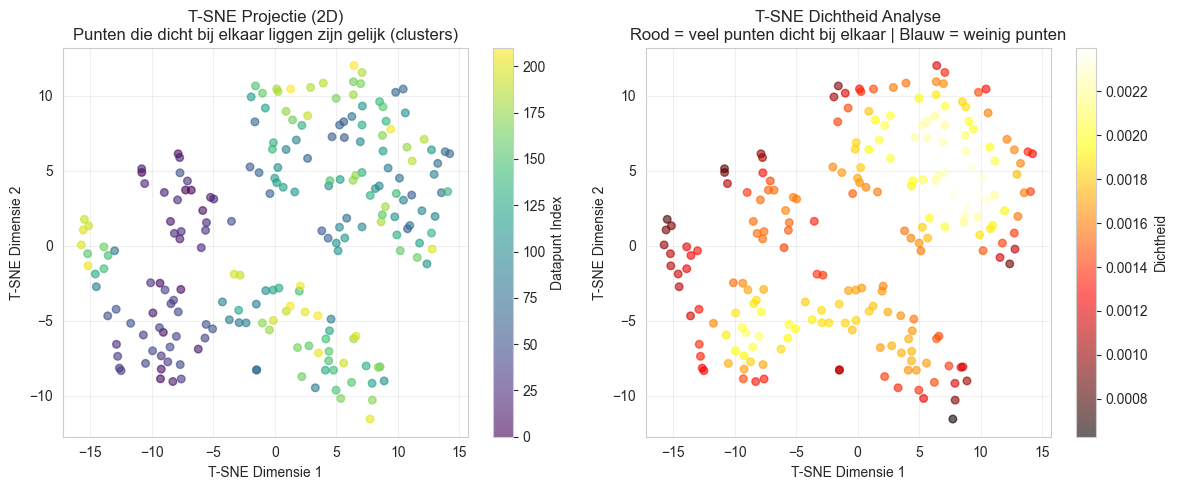


Gedetecteerde clusters (DBSCAN): 1
Losse punten (niet in cluster): 0

T-SNE laat lokale structuur (clusters) heel duidelijk!


In [7]:
# T-SNE Visualisatie
plt.figure(figsize=(12, 5))

# Grafiek 1: T-SNE scatter plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], alpha=0.6, s=30, c=range(len(tsne_df)), cmap='viridis')
plt.xlabel('T-SNE Dimensie 1')
plt.ylabel('T-SNE Dimensie 2')
plt.title('T-SNE Projectie (2D)\nPunten die dicht bij elkaar liggen zijn gelijk (clusters)')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Datapunt Index')

# Grafiek 2: Densiteit weergave (waar zitten de concentraties punten)
plt.subplot(1, 2, 2)
# Densiteitsplot voor T-SNE
from scipy.stats import gaussian_kde
xy = np.vstack([tsne_df['TSNE1'], tsne_df['TSNE2']])
z = gaussian_kde(xy)(xy)
scatter2 = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], alpha=0.6, s=30, c=z, cmap='hot')
plt.xlabel('T-SNE Dimensie 1')
plt.ylabel('T-SNE Dimensie 2')
plt.title('T-SNE Dichtheid Analyse\nRood = veel punten dicht bij elkaar | Blauw = weinig punten')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter2, label='Dichtheid')

plt.tight_layout()
plt.show()

# Cluster analyse
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=5, min_samples=5).fit(X_tsne)
n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
print(f"\nGedetecteerde clusters (DBSCAN): {n_clusters}")
print(f"Losse punten (niet in cluster): {list(clustering.labels_).count(-1)}")
print(f"\nT-SNE laat lokale structuur (clusters) heel duidelijk!")

## 3. UMAP (Uniform Manifold Approximation and Projection)

**Wat laat het zien:**
- UMAP is een moderne, niet-lineaire dimensionality reduction techniek
- Het bewaart zowel lokale als globale structuur van de data
- Sneller dan T-SNE en vaak beter in het behouden van globale patronen
- Gebaseerd op topologische principia (manifold learning)

**Voordelen:**
- Sneller dan T-SNE
- Bewaart beter zowel globale als lokale structuur
- Schaalbaar naar grotere datasets
- Minder gevoelig voor parameters

**Nadelen:**
- Moeilijker te interpreteren dan PCA
- Kan nog steeds misleidend zijn voor globale afstanden
- Minder onderzoeks- en theoretische basis dan PCA

In [8]:
# Pas UMAP toe
print("UMAP berekenen...")
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Maak een dataframe met UMAP resultaten
umap_df = pd.DataFrame(
    X_umap,
    columns=['UMAP1', 'UMAP2']
)

print(f"UMAP transformatie voltooid")
print(f"Shape: {X_umap.shape}")

UMAP berekenen...
UMAP transformatie voltooid
Shape: (211, 2)


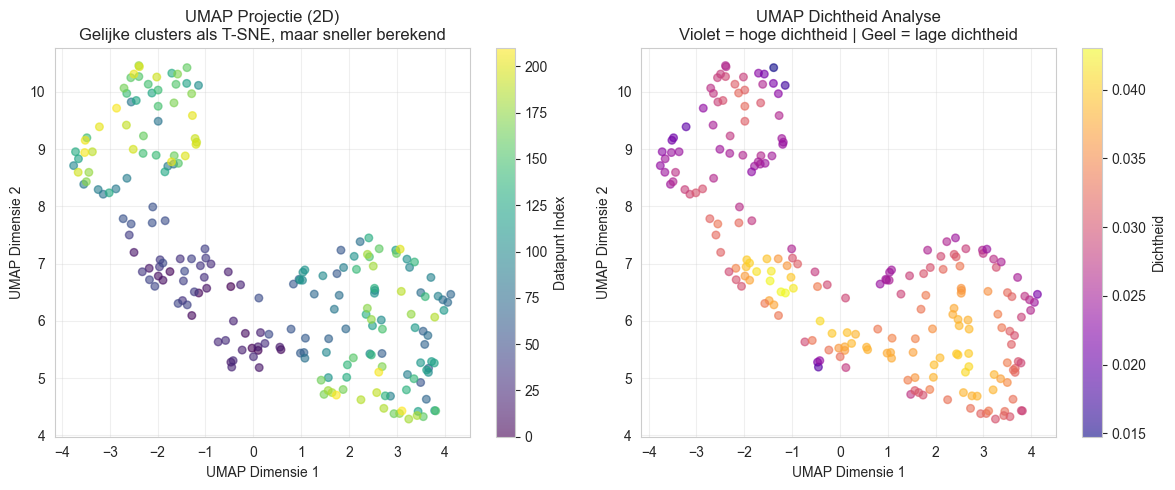

UMAP bewaart zowel clusters (lokaal) als overall structuur (globaal)


In [9]:
# UMAP Visualisatie
plt.figure(figsize=(12, 5))

# Grafiek 1: UMAP scatter plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], alpha=0.6, s=30, c=range(len(umap_df)), cmap='viridis')
plt.xlabel('UMAP Dimensie 1')
plt.ylabel('UMAP Dimensie 2')
plt.title('UMAP Projectie (2D)\nGelijke clusters als T-SNE, maar sneller berekend')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Datapunt Index')

# Grafiek 2: UMAP dichtheid
plt.subplot(1, 2, 2)
xy = np.vstack([umap_df['UMAP1'], umap_df['UMAP2']])
z = gaussian_kde(xy)(xy)
scatter2 = plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], alpha=0.6, s=30, c=z, cmap='plasma')
plt.xlabel('UMAP Dimensie 1')
plt.ylabel('UMAP Dimensie 2')
plt.title('UMAP Dichtheid Analyse\nViolet = hoge dichtheid | Geel = lage dichtheid')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter2, label='Dichtheid')

plt.tight_layout()
plt.show()

print("UMAP bewaart zowel clusters (lokaal) als overall structuur (globaal)")

## Vergelijking van alle drie technieken

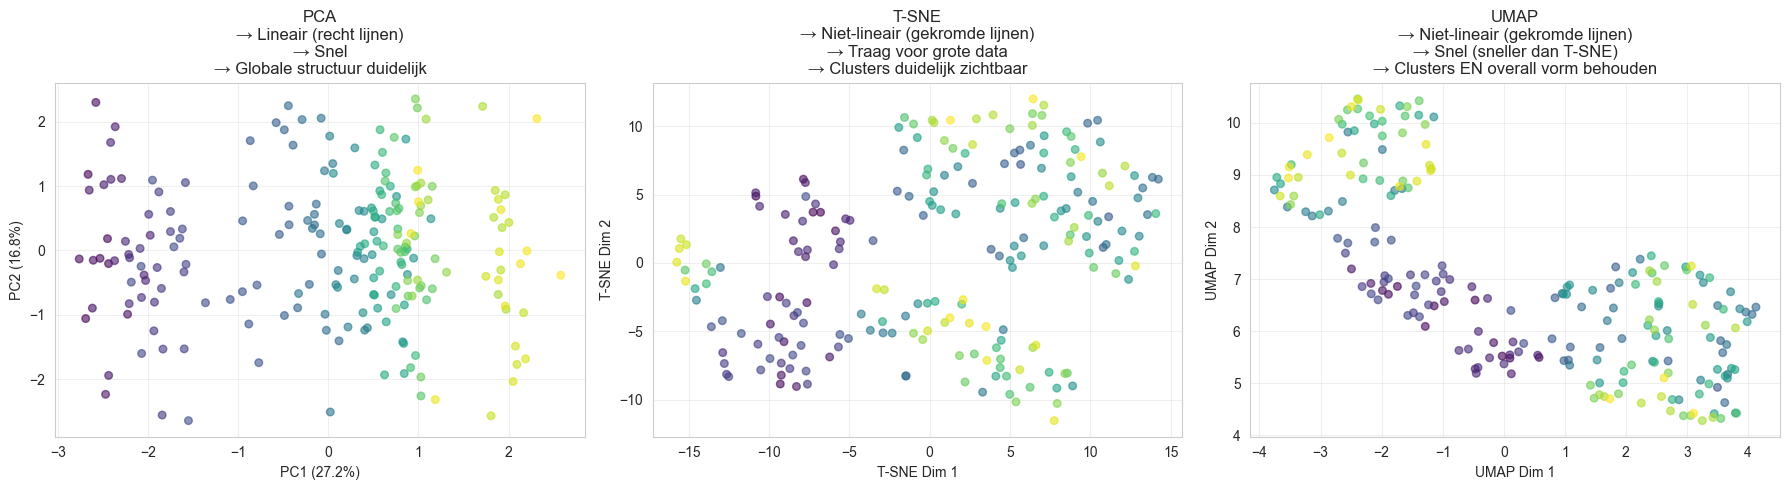


GIDS: WELKE TECHNIEK MOET JE GEBRUIKEN?

📊 PCA:
   ZIE JE: Een grove spreiding van punten (lineaire patronen)
   GEBRUIK VOOR: Snelle analyse, feature importance, als je veel dimensies hebt
   ✓ Snel en schaalbaar
   ✓ Je kunt zien welke originele features belangrijk zijn
   ✗ Mist niet-lineaire patroon in data

🎯 T-SNE:
   ZIE JE: Duidelijke clusters/groepen gescheiden van elkaar
   GEBRUIK VOOR: Zoeken naar groepen in je data, onderzoekswerk
   ✓ Clusters zijn HEEL duidelijk
   ✓ Perfect voor exploratory analysis
   ✗ Traag (uren voor grote datasets)
   ✗ Globale afstanden tussen clusters zijn niet betekenisvol

⚡ UMAP:
   ZIE JE: Clusters die zichtbaar zijn EN goede overall structuur
   GEBRUIK VOOR: Best-of-both-worlds scenario, grote datasets
   ✓ Snel (minuten vs uren)
   ✓ Bewaart zowel clusters als overall vorm
   ✓ Moderne methode
   ✗ Moeilijker uit te leggen dan PCA

CONCRETE VOORBEELD:
Stel je hebt 10.000 punten met 500 features
  → PCA: 1 seconde, ziet overkoepelend patro

In [ ]:
# Vergelijking van alle drie technieken naast elkaar
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PCA
scatter1 = axes[0].scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6, s=30, c=range(len(pca_df)), cmap='viridis')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('PCA\n→ Lineair (recht lijnen)\n→ Snel\n→ Globale structuur duidelijk')
axes[0].grid(True, alpha=0.3)

# T-SNE
scatter2 = axes[1].scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], alpha=0.6, s=30, c=range(len(tsne_df)), cmap='viridis')
axes[1].set_xlabel('T-SNE Dim 1')
axes[1].set_ylabel('T-SNE Dim 2')
axes[1].set_title('T-SNE\n→ Niet-lineair (gekromde lijnen)\n→ Traag voor grote data\n→ Clusters duidelijk zichtbaar')
axes[1].grid(True, alpha=0.3)

# UMAP
scatter3 = axes[2].scatter(umap_df['UMAP1'], umap_df['UMAP2'], alpha=0.6, s=30, c=range(len(umap_df)), cmap='viridis')
axes[2].set_xlabel('UMAP Dim 1')
axes[2].set_ylabel('UMAP Dim 2')
axes[2].set_title('UMAP\n→ Niet-lineair (gekromde lijnen)\n→ Snel (sneller dan T-SNE)\n→ Clusters EN overall vorm behouden')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*90)
print("GIDS: WELKE TECHNIEK MOET JE GEBRUIKEN?")
print("="*90)
print("\nPCA:")
print("   ZIE JE: Een grove spreiding van punten (lineaire patronen)")
print("   GEBRUIK VOOR: Snelle analyse, feature importance, als je veel dimensies hebt")
print("   Snel en schaalbaar")
print("   Je kunt zien welke originele features belangrijk zijn")
print("   Mist niet-lineaire patroon in data")

print("\nT-SNE:")
print("   ZIE JE: Duidelijke clusters/groepen gescheiden van elkaar")
print("   GEBRUIK VOOR: Zoeken naar groepen in je data, onderzoekswerk")
print("   Clusters zijn HEEL duidelijk")
print("   Perfect voor exploratory analysis")
print("   Traag (uren voor grote datasets)")
print("   Globale afstanden tussen clusters zijn niet betekenisvol")

print("\nUMAP:")
print("   ZIE JE: Clusters die zichtbaar zijn EN goede overall structuur")
print("   GEBRUIK VOOR: Best-of-both-worlds scenario, grote datasets")
print("   Snel (minuten vs uren)")
print("   Bewaart zowel clusters als overall vorm")
print("   Moderne methode")
print("   Moeilijker uit te leggen dan PCA")

print("\n" + "="*90)
print("CONCRETE VOORBEELD:")
print("="*90)
print("Stel je hebt 10.000 punten met 500 features")
print("  PCA: 1 seconde, ziet overkoepelend patroon")
print("  T-SNE: 30 minuten, ziet 7 duidelijke clusters")
print("  UMAP: 2 minuten, ziet 7 clusters EN de overall vorm")
print("="*90)